# Preprocessing

## Import

In [1]:
import glob
import numpy as np
import pandas as pd
import subprocess
import os

import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm

# from config import DATA_DIR, SCRIPTS_DIR, STRUCTURES_DIR
# from utils.generic_utils import remove_abc

## Path

In [2]:
df_path = '/home/matyus/Downloads/Project/notebooks/test_data/sabdab_summary_all.tsv'
residues_path = '/home/matyus/Downloads/Project/notebooks/test_data/lists_of_residues/'
structures_path = '/home/matyus/Downloads/all_structures/chothia/'
dccm_map_path = '/home/matyus/Downloads/Project/notebooks/test_data/dccm_maps/'
scripts_path = '/home/matyus/Downloads/Project/scripts/'
file_residues_paths = sorted(glob.glob(os.path.join(residues_path, '*.npy')))
chain_lengths_path = '/home/matyus/Downloads/Project/notebooks/test_data/chain_lengths'

## Create summary tsv

In [12]:
import pandas as pd

# Load the data
data = pd.read_csv('/home/matyus/Downloads/Project/notebooks/test_data/sabdab_summary_all.tsv', sep='\t')

# List of PDB names to filter
pdb_names = ['1a4k', '1m7i', '1mlc', '1p2c', '1t66', '1tzi', '1yej', '2i5y', '2p45', '2r56', '3bpc', '3eoa', '3g5y', '3o6l', '3vw3', '4f3f', '4fab', 
             '4kht', '4r8w', '4rgo', '4u6v', '4yhi', '4yho', '5cjq', '5i8c', '5ugy', '5vzy', '5w0k', '5w1m', '6axk', '6eyo']

# Filter the data
filtered_data = data[data['pdb'].isin(pdb_names)]

# Save the filtered data to a new TSV file
filtered_data.to_csv('summary.tsv', sep='\t', index=False)

## Clean df

In [30]:
def clean_df(df_path, pathological, affinity_entries_only=True):
    """
    Cleans the database containing the PDB entries.

    Parameters:
    - df_path: str
        Path to the database file.
    - pathological: list
        PDB identifiers of antibodies that need to be excluded.
    - affinity_entries_only: bool
        If True, only consider data with affinity values.

    Returns:
    - df_pdbs: list
        PDB entries.
    - df_kds: list 
        Binding affinities.
    - df: pandas.DataFrame
        Cleaned database.
    """
    # Read the database
    df = pd.read_csv(df_path, sep='\t', header=0)[['pdb', 'antigen_type', 'affinity']]
    
    # Remove duplicates
    df.drop_duplicates(keep='first', subset='pdb', inplace=True)
    
    # Convert PDB identifiers to lowercase and remove '+' signs
    df['pdb'] = df['pdb'].str.lower().str.replace('+', '')
    
    # Filter entries based on antigen type
    df = df[(df.antigen_type.notna()) & (df.antigen_type != 'NA')][['pdb', 'affinity']]
    
    # If only entries with affinity are considered
    if affinity_entries_only:
        df = df[(df.affinity.notna()) & (df.affinity != 'None')]
    
    # Exclude pathological cases
    df = df[~df['pdb'].isin(pathological)]

    # df = df[:317]
    
    return list(df['pdb']), list(df['affinity']), df

In [31]:
pathological = ['5omm', '5i5k', '1uwx', '1mj7', '1qfw', '1qyg', '4ffz', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t', '3fku', '1oau', '1oay']
scfv = ['4gqp', '3etb', '3gkz', '3uze', '3uzq', '3gm0', '4f9l', '6ejg', '6ejm', '1h8s', '5dfw', '6cbp', '4f9p', '5kov', '1dzb', '5j74', '5aaw', '3uzv', '5aam', '3ux9', '5a2j', '5a2k', '5a2i', '3fku', '5yy4', '3uyp', '5jyl', '1y0l', '1p4b', '3kdm', '4lar', '4ffy', '2ybr', '1mfa', '5xj3', '5xj4', '4kv5', '5vyf'] 
pathological += scfv

entries, affinity, df = clean_df(df_path, pathological)

In [32]:
len(entries)

634

In [8]:
for i, entry in enumerate(entries):
    if entries[i] == '1m7i':
        print(i)

603


In [37]:
for i, entry in enumerate(entries):
    if entries[i] == '1m7i':
        print(i)

25


In [9]:
entries[603]

'1m7i'

In [22]:
df

,pdb,affinity
0,6fe4,9.600000e-09
5,5w08,4.000000e-08
11,2ny3,8.150000e-07
12,6h7o,1.400000e-10
14,1nca,8.300000e-09
...,...,...
1259,5d70,2.000000e-09
1260,2p48,1.160000e-07
1261,4zfg,5.000000e-09
1263,3idx,4.040000e-09


## generate fv pdb

#### generate fv pdb (modified)

In [9]:
def generate_fv_pdb(path, keepABC=True, lresidues=False, hupsymchain=None, lupsymchain=None, residues_path=None, selection='_fv', alphafold=False, affinity_entries_only=True):
    """
    Generates a new PDB file going from the beginning of the CDR1 until the end of the CDR3.

    Parameters:
    - path: str
        Path of a Chothia-numbered PDB file.
    - keepABC: bool
        Keeps residues whose name ends with a letter from 'A' to 'Z'.
    - lresidues: bool
        The names of each residue are stored in ``residues_path``.
    - hupsymchain: int
        Upper limit of heavy chain residues due to a change in the numbering convention. Only useful when using ``AlphaFold``.
    - lupsymchain: int
        Upper limit of light chain residues due to a change in the numbering convention. Only useful when using ``AlphaFold``.
    - residues_path: str
        Path to the folder containing the list of residues per entry.
    - selection: str
        Considered portion of antibody chains.
    - alphafold: bool
        True if the test structure was folded using ``AlphaFold``.
    """
    if residues_path is None:
        raise ValueError("residues_path must be specified")

    rpath = residues_path
    list_residues = ['START']

    with open(path, 'r') as f:
        content = f.readlines()
        header_lines_important = range(4)
        header_lines = [content[i][0] == 'R' for i in range(len(content))].count(True)
        h_range = range(1, 114)
        l_range = range(1, 108)
        start_chain = 21
        chain_range = slice(start_chain, start_chain + 1)
        res_range = slice(23, 26)
        res_extra_letter = 26  # sometimes includes a letter 'A', 'B', 'C', ...
        h_chain_key = 'HCHAIN'
        l_chain_key = 'LCHAIN'
        antigen_chain_key = 'AGCHAIN'
        idx_list = list(header_lines_important)
        idx_list_l = []
        idx_list_antigen = []
        antigen_chains = []
        new_path = path[:-4] + selection + path[-4:]
        # Getting the names of the heavy and antigen chains
        line = content[header_lines_important[-1]]
        if line.find(h_chain_key) != -1:
            h_pos = line.find(h_chain_key) + len(h_chain_key) + 1
            h_chain = line[h_pos:h_pos + 1]
            antigen_pos = line.find(antigen_chain_key) + len(antigen_chain_key) + 1
            antigen_chains.append(line[antigen_pos:antigen_pos + 1])
            for i in range(3):
                if line[antigen_pos + 2 * i + 1] in [',', ';']:
                    antigen_chains.append(line[antigen_pos + 2 * i + 2])  # If two (or more) interacting antigen chains present
        else:
            # useful when using AlphaFold
            h_chain = 'A'
            l_chain = 'B'
            antigen_chains = ['C', 'D', 'E']
            idx_list = [0]
            h_range = range(1 - hupsymchain, hupsymchain - hupsymchain)
            l_range = range(1 - lupsymchain, lupsymchain - lupsymchain)
            h_pos = start_chain
            l_pos = start_chain

        if line.find(l_chain_key) != -1:
            l_pos = line.find(l_chain_key) + len(l_chain_key) + 1
            l_chain = line[l_pos:l_pos + 1]
        elif not alphafold:
            l_chain = None

        # Checking if H and L chains have the same name
        if l_chain is not None and h_chain.upper() == l_chain.upper():
            pathologic = True
            h_chain = h_chain.upper()
            l_chain = h_chain.lower()
        elif antigen_chains is not None and not affinity_entries_only and (h_chain.upper() in antigen_chains or (l_chain is not None and l_chain.upper() in antigen_chains)):
            pathologic = True
        else:
            pathologic = False

        # Processing the PDB file
        with open(new_path, 'w') as new_file:
            for line in content:
                if line.startswith('ATOM'):
                    chain_id = line[chain_range]
                    residue_number = int(line[res_range])
                    if chain_id == h_chain and residue_number in h_range:
                        new_file.write(line)
                    elif l_chain is not None and chain_id == l_chain and residue_number in l_range:
                        new_file.write(line)
                    elif chain_id in antigen_chains:
                        new_file.write(line)

        # Optionally, store residue names
        if lresidues:
            with open(rpath + path.split('/')[-1][:-4] + '_residues.txt', 'w') as res_file:
                for residue in list_residues:
                    res_file.write(residue + '\n')

    return new_path

#### generate_fv_pdb from antipasti

In [10]:
def generate_fv_pdb(path, residues_path, stage='training', selection='_fv', affinity_entries_only=True, alphafold=False, ag_agnostic=False, cmaps=False, 
                    keepABC=True, lresidues=False, hupsymchain=None, lupsymchain=None):
        r"""Generates a new PDB file going from the beginning of the CDR1 until the end of the CDR3.

        Parameters
        ----------
        path: str
            Path of a Chothia-numbered PDB file.
        keepABC: bool
            Keeps residues whose name ends with a letter from 'A' to 'Z'.
        lresidues: bool
            The names of each residue are stored in ``self.residues_path``.
        upsymchain: int
            Upper limit of heavy chain residues due to a change in the numbering convention. Only useful when using ``AlphaFold``.
        lupsymchain: int
            Upper limit of light chain residues due to a change in the numbering convention. Only useful when using ``AlphaFold``.

        """
        if stage == 'training':
            rpath = residues_path
        else:
            rpath = test_residues_path
        list_residues = ['START']

        with open(path, 'r') as f: # needs to be Chothia-numbered
            content = f.readlines()
            header_lines_important = range(4)
            header_lines = [content[i][0]=='R' for i in range(len(content))].count(True)
            h_range = range(1, 114)
            l_range = range(1, 108)
            start_chain = 21
            chain_range = slice(start_chain, start_chain+1)
            res_range = slice(23, 26)
            res_extra_letter = 26 #sometimes includes a letter 'A', 'B', 'C', ...
            h_chain_key = 'HCHAIN'
            l_chain_key = 'LCHAIN'
            antigen_chain_key = 'AGCHAIN'
            idx_list = list(header_lines_important)
            idx_list_l = []
            idx_list_antigen = []
            antigen_chains = []
            new_path = path[:-4] + selection + path[-4:]
            # Getting the names of the heavy and antigen chains
            line = content[header_lines_important[-1]]
            if line.find(h_chain_key) != -1:
                h_pos = line.find(h_chain_key) + len(h_chain_key) + 1
                h_chain = line[h_pos:h_pos+1]
                antigen_pos = line.find(antigen_chain_key) + len(antigen_chain_key) + 1
                antigen_chains.append(line[antigen_pos:antigen_pos+1])
                for i in range(3):
                    if line[antigen_pos+2*i+1] in [',', ';']:
                        antigen_chains.append(line[antigen_pos+2*i+2]) # If two (or more) interacting antigen chains present
            else:
                # useful when using AlphaFold
                h_chain = 'A' 
                l_chain = 'B'
                antigen_chains = ['C', 'D', 'E']
                idx_list = [0]
                h_range = range(1-self.h_offset, hupsymchain-self.h_offset)
                l_range = range(1-self.l_offset, lupsymchain-self.l_offset)
                h_pos = start_chain
                l_pos = start_chain

            if line.find(l_chain_key) != -1: 
                l_pos = line.find(l_chain_key) + len(l_chain_key) + 1
                l_chain = line[l_pos:l_pos+1]
            elif alphafold is False: 
                l_chain = None
                
            # Checking if H and L chains have the same name
            if l_chain is not None and h_chain.upper() == l_chain.upper():
                pathologic = True
                h_chain = h_chain.upper()
                l_chain = h_chain.lower()
            elif antigen_chains is not None and affinity_entries_only is False and (h_chain.upper() in antigen_chains or (l_chain is not None and l_chain.upper() in antigen_chains)):
                pathologic = True
                h_chain = h_chain.lower()
                if l_chain is not None:
                    l_chain = l_chain.lower()
            else:
                pathologic = False

            # Checks for matching identifiers
            if pathologic:
                if 'X' not in antigen_chains:
                    new_hchain = 'X'
                else: 
                    new_hchain = 'W'
                if 'Y' not in antigen_chains:
                    new_lchain = 'Y'
                else: 
                    new_lchain = 'Z'
            else:
                new_hchain = h_chain
                new_lchain = l_chain   
                           
            # Obtaining lines for the heavy chain variable region first
            for i, line in enumerate(content[header_lines:]):
                if line[chain_range].find(h_chain) != -1 and int(line[res_range]) in h_range:
                    if (line[res_extra_letter] == ' ' or keepABC == True) and line.find('HETATM') == -1:
                        idx_list.append(i+header_lines)
                        if lresidues == True:
                            full_res = line[res_range] + line[res_extra_letter]
                            if pathologic:
                                full_res = new_hchain + full_res
                            else:
                                full_res = line[chain_range] + full_res
                            if full_res != list_residues[-1]:
                                list_residues.append(full_res)

            # This separation ensures that heavy chain residues are enlisted first
            if l_chain is not None:
                for i, line in enumerate(content[header_lines:]):
                    if line[chain_range].find(l_chain) != -1 and int(line[res_range]) in l_range:
                        if (line[res_extra_letter] == ' ' or keepABC == True) and line.find('HETATM') == -1:
                            idx_list_l.append(i+header_lines)
                            if lresidues == True:
                                full_res = line[res_range] + line[res_extra_letter]
                                if pathologic:
                                    full_res = new_lchain + full_res
                                else:
                                    full_res = line[chain_range] + full_res
                                if full_res != list_residues[-1]:
                                    list_residues.append(full_res)                   
        
            # Obtaining antigen(s)
            for i, line in enumerate(content[header_lines:]):
                if any(line[chain_range] in agc for agc in antigen_chains) and h_chain not in antigen_chains and l_chain not in antigen_chains:
                    idx_list_antigen.append(i+header_lines)

        # List with name of every residue is saved if selected
        if lresidues == True:
            list_residues.append('END')
            saving_path = rpath + path[-8:-4] + '.npy'
            #if not os.path.exists(saving_path):
            np.save(saving_path, list_residues)
            
        # Creating new file
        with open(new_path, 'w') as f_new:
            f_new.writelines([content[l] for l in idx_list[:header_lines_important[-1]]])
            if l_chain is not None and alphafold is False:
                f_new.writelines([content[l][:h_pos]+new_hchain+content[l][h_pos+1:l_pos]+new_lchain+content[l][l_pos+1:] for l in idx_list[header_lines_important[-1]:header_lines_important[-1]+1]])
            else:
                f_new.writelines([content[l][:h_pos]+new_hchain+content[l][h_pos+1:] for l in idx_list[header_lines_important[-1]:header_lines_important[-1]+1]])
            f_new.writelines([content[l][:start_chain-5]+' '+content[l][start_chain-4:start_chain]+new_hchain+content[l][start_chain+1:] for l in idx_list[header_lines_important[-1]+1:]])
            if l_chain is not None:
                f_new.writelines([content[l][:start_chain-5]+' '+content[l][start_chain-4:start_chain]+new_lchain+content[l][start_chain+1:] for l in idx_list_l])
            if not ag_agnostic:
                f_new.writelines([content[l] for l in idx_list_antigen])
            if not cmaps:
                f_new.writelines([content[l] for l in range(len(content)) if content[l][0:6] == 'HETATM' and content[l][chain_range] in [h_chain, l_chain] and l not in idx_list+idx_list_l+idx_list_antigen])
            

In [9]:
path = '/home/matyus/Downloads/Project/notebooks/test_data/structure/1m7i.pdb'

generate_fv_pdb(path, residues_path, lresidues=True)

In [39]:
import numpy as np
data = np.load('/home/matyus/Downloads/Project/notebooks/test_data/lists_of_residues/1a4k.npy')
data

array(['START', 'H  1 ', 'H  2 ', 'H  3 ', 'H  4 ', 'H  5 ', 'H  6 ',
       'H  7 ', 'H  8 ', 'H  9 ', 'H 10 ', 'H 11 ', 'H 12 ', 'H 13 ',
       'H 14 ', 'H 15 ', 'H 16 ', 'H 17 ', 'H 18 ', 'H 19 ', 'H 20 ',
       'H 21 ', 'H 22 ', 'H 23 ', 'H 24 ', 'H 25 ', 'H 26 ', 'H 27 ',
       'H 28 ', 'H 29 ', 'H 30 ', 'H 31 ', 'H 32 ', 'H 33 ', 'H 34 ',
       'H 35 ', 'H 36 ', 'H 37 ', 'H 38 ', 'H 39 ', 'H 40 ', 'H 41 ',
       'H 42 ', 'H 43 ', 'H 44 ', 'H 45 ', 'H 46 ', 'H 47 ', 'H 48 ',
       'H 49 ', 'H 50 ', 'H 51 ', 'H 52 ', 'H 52A', 'H 53 ', 'H 54 ',
       'H 55 ', 'H 56 ', 'H 57 ', 'H 58 ', 'H 59 ', 'H 60 ', 'H 61 ',
       'H 62 ', 'H 63 ', 'H 64 ', 'H 65 ', 'H 66 ', 'H 67 ', 'H 68 ',
       'H 69 ', 'H 70 ', 'H 71 ', 'H 72 ', 'H 73 ', 'H 74 ', 'H 75 ',
       'H 76 ', 'H 77 ', 'H 78 ', 'H 79 ', 'H 80 ', 'H 81 ', 'H 82 ',
       'H 82A', 'H 82B', 'H 82C', 'H 83 ', 'H 84 ', 'H 85 ', 'H 86 ',
       'H 87 ', 'H 88 ', 'H 89 ', 'H 90 ', 'H 91 ', 'H 92 ', 'H 93 ',
       'H 94 ', 'H 9

In [9]:
import numpy as np
data2 = np.load('/home/matyus/Downloads/ANTIPASTI-main/notebooks/test_data/list_of_residues/1a4k.npy')
data2

array(['START', 'H  2 ', 'H  3 ', 'H  4 ', 'H  5 ', 'H  6 ', 'H  7 ',
       'H  8 ', 'H  9 ', 'H 10 ', 'H 11 ', 'H 12 ', 'H 13 ', 'H 14 ',
       'H 15 ', 'H 16 ', 'H 17 ', 'H 18 ', 'H 19 ', 'H 20 ', 'H 21 ',
       'H 22 ', 'H 23 ', 'H 24 ', 'H 25 ', 'H 26 ', 'H 27 ', 'H 28 ',
       'H 29 ', 'H 30 ', 'H 31 ', 'H 32 ', 'H 33 ', 'H 34 ', 'H 35 ',
       'H 36 ', 'H 37 ', 'H 38 ', 'H 39 ', 'H 40 ', 'H 41 ', 'H 42 ',
       'H 43 ', 'H 44 ', 'H 45 ', 'H 46 ', 'H 47 ', 'H 48 ', 'H 49 ',
       'H 50 ', 'H 51 ', 'H 52 ', 'H 52A', 'H 53 ', 'H 54 ', 'H 55 ',
       'H 56 ', 'H 57 ', 'H 58 ', 'H 59 ', 'H 60 ', 'H 61 ', 'H 62 ',
       'H 63 ', 'H 64 ', 'H 65 ', 'H 66 ', 'H 67 ', 'H 68 ', 'H 69 ',
       'H 70 ', 'H 71 ', 'H 72 ', 'H 73 ', 'H 74 ', 'H 75 ', 'H 76 ',
       'H 77 ', 'H 78 ', 'H 79 ', 'H 80 ', 'H 81 ', 'H 82 ', 'H 82A',
       'H 82B', 'H 82C', 'H 83 ', 'H 84 ', 'H 85 ', 'H 86 ', 'H 87 ',
       'H 88 ', 'H 89 ', 'H 90 ', 'H 91 ', 'H 92 ', 'H 93 ', 'H 94 ',
       'H 95 ', 'H 9

## generate maps

#### single file generate map

In [10]:
def generate_maps(structures_path, dccm_map_path, entry, scripts_path, entries, selection='_fv', file_type_input='.pdb', cmaps=False, modes=30, cmaps_thr=8.0):
        r"""Generates the normal mode correlation maps.

        """
        
        file_name = entry + selection
        path = structures_path + file_name + file_type_input
        new_path = dccm_map_path + entry
        # generate_fv_pdb(structures_path+entry+file_type_input, lresidues=True) 
        if not cmaps:
            subprocess.call(['/usr/bin/Rscript', str(scripts_path)+'pdb_to_dccm.r', str(path), str(new_path), str(modes)], shell=True, stdout=open(os.devnull, 'wb'))
        else:
            subprocess.call(['python', str(scripts_path)+'generate_contact_maps.py', str(path), str(new_path), str(cmaps_thr)], stdout=open(os.devnull, 'wb'))
        if os.path.exists(path):
            os.remove(path)
        
        # if i % 25 == 0: 
        #     print('Map ' + str(i+1) + ' out of ' + str(len(entries)) + ' processed.')

#### batch generate maps

In [11]:
def generate_maps(entries, structures_path, residues_path, dccm_map_path, scripts_path, selection='_fv', file_type_input='.pdb', cmaps=False, modes=30, 
                  cmaps_thr=8.0):
    """
    Generates the normal mode correlation maps.

    Parameters:
    - entries: list
        List of PDB entries to process.
    - selection: str
        Suffix to append to filenames indicating the selection of the structure.
    - structures_path: str
        Path to the directory containing structure files.
    - file_type_input: str
        File extension of the input structure files.
    - dccm_map_path: str
        Path where the generated maps should be saved.
    - scripts_path: str
        Path to the directory containing scripts for map generation.
    - cmaps: bool
        If True, use contact maps instead of normal mode correlation maps.
    - modes: int
        Number of modes to consider in the correlation map generation.
    - cmaps_thr: float
        Threshold for contact map generation.
    """
    for i, entry in enumerate(entries):
        file_name = entry + selection
        path = os.path.join(structures_path, file_name + file_type_input)
        new_path = os.path.join(dccm_map_path, entry)
        generate_fv_pdb(structures_path+entry+file_type_input, residues_path, lresidues=True)

        if not cmaps:
            # Call an external R script to generate normal mode correlation maps
            subprocess.call(['/usr/bin/Rscript', os.path.join(scripts_path, 'pdb_to_dccm.r'), path, new_path, str(modes)], shell=False, stdout=open(os.devnull, 'wb'))
        else:
            # Call a Python script to generate contact maps
            subprocess.call(['python', os.path.join(scripts_path, 'generate_contact_maps.py'), path, new_path, str(cmaps_thr)], stdout=open(os.devnull, 'wb'))

        if os.path.exists(path):
            os.remove(path)

        if i % 25 == 0:
            print('Map ' + str(i + 1) + ' out of ' + str(len(entries)) + ' processed.')

In [11]:
entry = entries[603]

generate_maps(structures_path, dccm_map_path, entry, scripts_path, entries, cmaps=True)

In [42]:
data_dccm = np.load('/home/matyus/Downloads/Project/notebooks/test_data/dccm_maps/1a4k.npy')
data_dccm

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [12]:

generate_maps(entries, structures_path, residues_path, dccm_map_path, scripts_path, cmaps=False)

Map 1 out of 317 processed.


KeyboardInterrupt: 

In [22]:
path = '/home/matyus/Downloads/Project/notebooks/test_data/structure/1m7i_fv.pdb'
new_path = '/home/matyus/Downloads/Project/notebooks/test_data/dccm_maps/1m7i'
modes = 30

subprocess.call(['/usr/bin/Rscript', str(scripts_path)+'pdb_to_dccm.r', str(path), str(new_path), str(modes)], shell=False, stdout=open(os.devnull, 'wb'))

0

In [21]:
scriptpath = '/home/matyus/Downloads/sampleScript.R'
arg = '--vanilla'

subprocess.call(['/usr/bin/Rscript', arg, str(scriptpath)])

[1] "This is testing text using R"


0

In [28]:
data_dccm = np.load('/home/matyus/Downloads/Project/notebooks/test_data/dccm_maps/1a4k.npy')
data_dccm

array([[ 1.        ,  0.9780764 ,  0.94392698, ..., -0.12231404,
        -0.16474371, -0.12149169],
       [ 0.9780764 ,  1.        ,  0.9268307 , ..., -0.11813491,
        -0.17114362, -0.12837615],
       [ 0.94392698,  0.9268307 ,  1.        , ..., -0.17038113,
        -0.22297767, -0.1685073 ],
       ...,
       [-0.12231404, -0.11813491, -0.17038113, ...,  1.        ,
         0.9290144 ,  0.89142148],
       [-0.16474371, -0.17114362, -0.22297767, ...,  0.9290144 ,
         1.        ,  0.95282452],
       [-0.12149169, -0.12837615, -0.1685073 , ...,  0.89142148,
         0.95282452,  1.        ]])

## get lists of lengths

from antipasti

In [ ]:
def get_lists_of_lengths(self, selected_entries):
        r"""Retrieves lists with the lengths of the heavy and light chains.
        
        Parameters
        ----------
        selected_entries: list
            PDB valid entries.

        Returns
        -------
        heavy: list
            Lengths of the heavy chains. In the context of the prediction stage, this list has one element.
        light: list 
            Lengths of the light chains. In the context of the prediction stage, this list has one element.
        selected_entries: list
            PDB valid entries. In the context of the prediction stage, this list has one element.

        """
        heavy = []
        light = []

        if self.stage == 'training':
            rpath = self.residues_path
        else:
            rpath = self.test_residues_path

        for entry in selected_entries:
            list_of_residues = np.load(rpath+entry+'.npy')[1:-1]
            h_chain = list_of_residues[0][0]
            l_chain = list_of_residues[-1][0]

            heavy.append(len([idx for idx in list_of_residues if idx[0] == h_chain]))
            if h_chain != l_chain:
                light.append(len([idx for idx in list_of_residues if idx[0] == l_chain]))
            else:
                light.append(0)

        return heavy, light, selected_entries

modified

In [25]:
def get_lists_of_lengths(selected_entries, residues_path):
    """
    Retrieves lists with the lengths of the heavy and light chains.

    Parameters:
    - selected_entries: list
        List of PDB valid entries.
    - residues_path: str
        Path to the directory containing residue data files.

    Returns:
    - heavy: list
        Lengths of the heavy chains.
    - light: list 
        Lengths of the light chains.
    - selected_entries: list
        PDB valid entries.
    """
    heavy = []
    light = []

    for entry in selected_entries:
        # Load the residue data for each entry
        list_of_residues = np.load(os.path.join(residues_path, entry + '.npy'))[1:-1]  # Exclude 'START' and 'END'
        h_chain = list_of_residues[0][0]  # Assume first residue chain label is heavy chain
        l_chain = list_of_residues[-1][0]  # Assume last residue chain label is light chain

        # Calculate the length of the heavy chain
        heavy_length = len([res for res in list_of_residues if res[0] == h_chain])
        heavy.append(heavy_length)

        # Calculate the length of the light chain if it exists and is different from the heavy chain
        if h_chain != l_chain:
            light_length = len([res for res in list_of_residues if res[0] == l_chain])
            light.append(light_length)
        else:
            light.append(0)  # No light chain or same as heavy chain

    return heavy, light, selected_entries

In [12]:

dccm_paths = sorted(glob.glob(os.path.join(dccm_map_path, '*.npy')))
selected_entries = [dccm_paths[i][-8:-4] for i in range(len(dccm_paths))]

get_lists_of_lengths(selected_entries, residues_path)

([119, 120], [112, 111], ['1a4k', '1m7i'])

## get max min chains

#### modified

In [16]:
def get_max_min_chains(file_residues_paths, selected_entries, heavy, light):
    """
    Returns the longest and shortest possible chains.

    Parameters:
    - file_residues_paths: list
        Paths to the files containing residue data.
    - selected_entries: list
        List of selected PDB entries.
    - heavy: list
        List containing the lengths of heavy chains for each entry.
    - light: list
        List containing the lengths of light chains for each entry.

    Returns:
    - max_res_list_h: list
        List of unique residues in the longest heavy chain.
    - max_res_list_l: list
        List of unique residues in the longest light chain.
    - min_res_list_h: list
        List of common residues in the shortest heavy chain.
    - min_res_list_l: list
        List of common residues in the shortest light chain.
    """
    max_res_list_h = []
    max_res_list_l = []
    min_res_list_h = []
    min_res_list_l = []

    # Initialize min lists with the first entry to compare against
    if file_residues_paths:
        first_residues = np.load(file_residues_paths[0])[1:-1]  # Exclude 'START' and 'END'
        min_res_list_h = [res for res in first_residues if res[0] == first_residues[0][0]]
        if first_residues[0][0] != first_residues[-1][0]:
            min_res_list_l = [res for res in first_residues if res[0] == first_residues[-1][0]]
        else:
            min_res_list_l = []

    for idx, f in enumerate(file_residues_paths):
        current_residues = np.load(f)[1:-1]  # Exclude 'START' and 'END'
        current_list_h = [res for res in current_residues if res[0] == current_residues[0][0]]
        current_list_l = [res for res in current_residues if res[0] == current_residues[-1][0]]

        # Update max lists
        max_res_list_h = list(set(max_res_list_h).union(set(current_list_h)))
        max_res_list_l = list(set(max_res_list_l).union(set(current_list_l)))

        # Update min lists
        min_res_list_h = list(set(min_res_list_h).intersection(set(current_list_h)))
        min_res_list_l = list(set(min_res_list_l).intersection(set(current_list_l)))

    return max_res_list_h, max_res_list_l, min_res_list_h, min_res_list_l

#### max min chains

In [14]:
def get_max_min_chains(file_residues_paths, selected_entries, heavy, light):
        r"""Returns the longest and shortest possible chains.

        """
        max_res_list_h = []
        max_res_list_l = []

        for f in file_residues_paths:
            idx = selected_entries.index(f[-8:-4])
            current_list_h = np.load(f)[1:heavy[idx]+1]
            current_list_l = np.load(f)[heavy[idx]+1:heavy[idx]+light[idx]+1]
            current_list_h = [x[1:] for x in current_list_h]
            current_list_l = [x[1:] for x in current_list_l]
            max_res_list_h += list(set(current_list_h).difference(max_res_list_h))
            max_res_list_l += list(set(current_list_l).difference(max_res_list_l))
            
        max_res_list_h = sorted(max_res_list_h, key=remove_abc)
        min_res_list_h = list(dict.fromkeys([x for x in max_res_list_h]))
        max_res_list_h = [x.strip() for x in max_res_list_h]

        max_res_list_l = sorted(max_res_list_l, key=remove_abc)
        min_res_list_l = list(dict.fromkeys([x for x in max_res_list_l]))
        max_res_list_l = [x.strip() for x in max_res_list_l]

        for f in file_residues_paths:
            idx = selected_entries.index(f[-8:-4])
            current_list_h = np.load(f)[1:heavy[idx]+1]
            current_list_l = np.load(f)[heavy[idx]+1:heavy[idx]+light[idx]+1]
            current_list_h = [x[1:] for x in current_list_h]
            current_list_l = [x[1:] for x in current_list_l]
            min_res_list_h = sorted(list(set(current_list_h).intersection(min_res_list_h)))
            min_res_list_l = sorted(list(set(current_list_l).intersection(min_res_list_l)))

        min_res_list_h = [x.strip() for x in min_res_list_h]
        min_res_list_l = [x.strip() for x in min_res_list_l]

        return max_res_list_h, max_res_list_l, min_res_list_h, min_res_list_l

In [15]:
def remove_abc(residue):
    """
    Returns the residue names without the final letter that indicates extension positions.

    """
    if residue[-1] != ' ':
        residue = str(residue[:-1]) + '.' + '{0:0=2d}'.format(ord(residue[-1])-64)
    return float(residue)

In [34]:

max_res_list_h, max_res_list_l, min_res_list_h, min_res_list_l = get_max_min_chains(file_residues_paths, selected_entries, heavy, light)

In [30]:
max_res_list_l

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '30A',
 '30B',
 '30C',
 '30D',
 '30E',
 '30F',
 '30G',
 '30H',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '95A',
 '95B',
 '95C',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '106A',
 '107']

## initialisation

modified initialisation

In [16]:
def initialisation(entries, structures_path, dccm_map_path, scripts_path, residues_path, chain_lengths_path, renew_maps=False, renew_residues=True):
    """
    Computes the normal mode correlation maps and retrieves lists with the lengths of the heavy and light chains.

    Parameters:
    - renew_maps: bool
        Compute all the normal mode correlation maps.
    - renew_residues: bool
        Retrieve the lists of residues for each entry.
    - entries: list
        List of PDB entries.
    - selection: str
        Suffix to append to filenames indicating the selection of the structure.
    - structures_path: str
        Path to the directory containing structure files.
    - file_type_input: str
        File extension of the input structure files.
    - dccm_map_path: str
        Path where the generated maps should be saved.
    - scripts_path: str
        Path to the directory containing scripts for map generation.
    - cmaps: bool
        If True, use contact maps instead of normal mode correlation maps.
    - modes: int
        Number of modes to consider in the correlation map generation.
    - cmaps_thr: float
        Threshold for contact map generation.
    - residues_path: str
        Path to the directory containing residue data files.
    - chain_lengths_path: str
        Path to the directory where chain lengths data should be saved.

    Returns:
    - heavy: list
        Lengths of the heavy chains.
    - light: list 
        Lengths of the light chains.
    - selected_entries: list
        PDB valid entries.
    """
    if renew_maps:
        generate_maps(entries, structures_path, residues_path, dccm_map_path, scripts_path, cmaps=True)

    dccm_paths = sorted(glob.glob(os.path.join(dccm_map_path, '*.npy')))
    selected_entries = [dccm_paths[i][-8:-4] for i in range(len(dccm_paths))]

    if renew_residues:
        heavy, light, selected_entries = get_lists_of_lengths(selected_entries, residues_path)
        np.save(os.path.join(chain_lengths_path, 'heavy_lengths.npy'), heavy)
        np.save(os.path.join(chain_lengths_path, 'light_lengths.npy'), light)
        np.save(os.path.join(chain_lengths_path, 'selected_entries.npy'), selected_entries)
    else:
        heavy = np.load(os.path.join(chain_lengths_path, 'heavy_lengths.npy')).astype(int)
        light = np.load(os.path.join(chain_lengths_path, 'light_lengths.npy')).astype(int)
        selected_entries = list(np.load(os.path.join(chain_lengths_path, 'selected_entries.npy')))

    assert len(selected_entries) == len(heavy) == len(light), "Mismatch in lengths of entries and chain lengths."

    return heavy, light, selected_entries

from antipasti

In [ ]:
def initialisation(self, renew_maps, renew_residues):
        r"""Computes the normal mode correlation maps and retrieves lists with the lengths of the heavy and light chains.

        Parameters
        ----------
        renew_maps: bool
            Compute all the normal mode correlation maps.
        renew_residues: bool
            Retrieve the lists of residues for each entry.

        Returns
        -------
        heavy: list
            Lengths of the heavy chains.
        light: list 
            Lengths of the light chains.
        selected_entries: list
            PDB valid entries.

        """

        if renew_maps:
            self.generate_maps()

        dccm_paths = sorted(glob.glob(os.path.join(self.dccm_map_path, '*.npy')))
        selected_entries = [dccm_paths[i][-8:-4] for i in range(len(dccm_paths))]

        if renew_residues:
            heavy, light, selected_entries = self.get_lists_of_lengths(selected_entries)
            np.save(self.chain_lengths_path+'heavy_lengths.npy', heavy)
            np.save(self.chain_lengths_path+'light_lengths.npy', light)
            np.save(self.chain_lengths_path+'selected_entries.npy', selected_entries)
        else:
            heavy = np.load(self.chain_lengths_path+'heavy_lengths.npy').astype(int)
            light = np.load(self.chain_lengths_path+'light_lengths.npy').astype(int)

        assert list(np.load(self.chain_lengths_path+'selected_entries.npy')) == selected_entries

        for entry in selected_entries:
            assert len(np.load(self.residues_path+entry+'.npy'))-2 == heavy[selected_entries.index(entry)] + light[selected_entries.index(entry)]

        return heavy, light, selected_entries

In [33]:

heavy, light, selected_entries = initialisation(entries, structures_path, dccm_map_path, scripts_path, residues_path, 
                                                chain_lengths_path)

In [31]:
import numpy as np
data_length = np.load('/home/matyus/Downloads/Project/notebooks/test_data/chain_lengths/heavy_lengths.npy')
len(data_length)

634

## generate masked image

modified function

In [33]:
def generate_masked_image(img, idx, file_residues_paths, selected_entries, max_res_list_h, max_res_list_l, heavy, light, ag_residues, stage='training', test_h=None, test_l=None):
    """
    Generates a masked normal mode correlation map.

    Parameters:
    - img: numpy.ndarray
        Original array containing no blank pixels.
    - idx: int
        Input index.
    - test_h: int
        Length of the heavy chain of an antibody in the test set.
    - test_l: int
        Length of the light chain of an antibody in the test set.
    - stage: str
        Indicates the stage of processing ('training' or 'testing').
    - file_residues_paths: list
        Paths to the files containing residue data.
    - selected_entries: list
        List of selected PDB entries.
    - max_res_list_h: list
        List of unique residues in the longest heavy chain.
    - max_res_list_l: list
        List of unique residues in the longest light chain.
    - ag_residues: int
        Number of residues in the antigen.

    Returns:
    - masked: numpy.ndarray
        Masked normal mode correlation map.
    - mask: numpy.ndarray
        Mask itself.
    """
    f = file_residues_paths[idx]
    f_res = np.load(f)
    max_res_h = len(max_res_list_h)
    max_res_l = len(max_res_list_l)
    max_res = max_res_h + max_res_l

    masked = np.zeros((max_res + ag_residues, max_res + ag_residues))
    mask = np.zeros((max_res + ag_residues, max_res + ag_residues))

    if stage != 'training':
        h = test_h
        l = test_l
    else:
        current_idx = selected_entries.index(f[-8:-4])
        h = heavy[current_idx]
        l = light[current_idx]

    current_list_h = f_res[1:h+1]
    current_list_h = [x[1:].strip() for x in current_list_h]
    current_list_l = f_res[h+1:h+l+1]
    current_list_l = [x[1:].strip() for x in current_list_l]

    idx_list_h = [i for i in range(max_res_h) if max_res_list_h[i] in current_list_h]
    idx_list_l = [i + max_res_h for i in range(max_res_l) if max_res_list_l[i] in current_list_l]
    idx_list = idx_list_h + idx_list_l + [i + max_res_h + max_res_l for i in range(min(ag_residues, img.shape[-1] - (h + l)))]

    for i in idx_list:
        for j in idx_list:
            masked[i, j] = img[i, j]
            mask[i, j] = 1

    return masked, mask

from antipasti

In [27]:
def generate_masked_image(img, idx, file_residues_paths, selected_entries, max_res_list_h, max_res_list_l, heavy, light, stage='training', test_h=None, 
                          test_l=None, alphafold=False, test_residues_path=None, test_pdb_id='1t66', ag_residues=0):
        r"""Generates a masked normal mode correlation map

        Parameters
        ----------
        img: numpy.ndarray
            Original array containing no blank pixels.
        idx: int
            Input index.
        test_h: int
            Length of the heavy chain of an antibody in the test set.
        test_l: int
            Length of the light chain of an antibody in the test set.

        Returns
        -------
        masked: numpy.ndarray
            Masked normal mode correlation map.
        mask: numpy.ndarray
            Mask itself.
        
        """
        if stage == 'training':    
            f = file_residues_paths[idx]
        elif alphafold is False:
            f = sorted(glob.glob(os.path.join(test_residues_path, '*'+test_pdb_id+'.npy')))[0]
        else:
            f = sorted(glob.glob(os.path.join(test_residues_path, '*'+test_pdb_id[:-3]+'.npy')))[0] # removing '_af' suffix
        antigen_max_pixels = ag_residues
        f_res = np.load(f)
        max_res_h = len(max_res_list_h)
        max_res_l = len(max_res_list_l)
        max_res = max_res_h + max_res_l 
        masked = np.zeros((max_res+antigen_max_pixels, max_res+antigen_max_pixels))
        mask = np.zeros((max_res+antigen_max_pixels, max_res+antigen_max_pixels))
        
        if stage != 'training':
            h = test_h
            l = test_l
        else:
            current_idx = selected_entries.index(f[-8:-4])
            h = heavy[current_idx]
            l = light[current_idx]

        current_list_h = f_res[1:h+1]
        current_list_h = [x[1:].strip() for x in current_list_h]
        current_list_l = f_res[h+1:h+l+1]
        current_list_l = [x[1:].strip() for x in current_list_l]    

        idx_list = [i for i in range(max_res_h) if max_res_list_h[i] in current_list_h]
        idx_list += [i+max_res_h for i in range(max_res_l) if max_res_list_l[i] in current_list_l]
        idx_list += [i+max_res_h+max_res_l for i in range(min(antigen_max_pixels, img.shape[-1]-(h+l)))]
        for k, i in enumerate(idx_list):
            for l, j in enumerate(idx_list):
                masked[i, j] = img[k, l]
                mask[i, j] = 1
            
        return masked, mask

In [28]:
file_path = '/home/matyus/Downloads/Project/notebooks/test_data/dccm_maps/1a4k.npy'
img = np.load(file_path)
idx = 0

masked, mask = generate_masked_image(img, idx, file_residues_paths, selected_entries, max_res_list_h, max_res_list_l, heavy, light)

In [29]:
masked

array([[ 1.        ,  0.9780764 ,  0.94392698, ..., -0.16474371,
         0.        , -0.12149169],
       [ 0.9780764 ,  1.        ,  0.9268307 , ..., -0.17114362,
         0.        , -0.12837615],
       [ 0.94392698,  0.9268307 ,  1.        , ..., -0.22297767,
         0.        , -0.1685073 ],
       ...,
       [-0.16474371, -0.17114362, -0.22297767, ...,  1.        ,
         0.        ,  0.95282452],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.12149169, -0.12837615, -0.1685073 , ...,  0.95282452,
         0.        ,  1.        ]])

## load training images

In [28]:
def load_training_images(dccm_map_path, selected_entries, pathological, entries, affinity, df, 
                         file_residues_paths, max_res_list_h, max_res_list_l, heavy, light, affinity_entries_only=True):
    """
    Returns the input/output pairs of the model and their corresponding labels.

    Parameters:
    - dccm_map_path: str
        Path where the DCCM maps are stored.
    - selected_entries: list
        List of selected PDB entries.
    - pathological: list
        List of entries that are considered pathological and should be excluded.
    - entries: list
        List of all entries.
    - affinity_entries_only: bool
        Flag to determine if only entries with affinity data should be processed.
    - affinity: list
        List of affinity values corresponding to the entries.
    - df: DataFrame
        DataFrame containing affinity data for validation.

    Returns:
    - imgs: numpy.ndarray
        Array of masked images.
    - kds: numpy.ndarray
        Array of log-transformed affinity values.
    - labels: list
        List of PDB IDs used.
    - raw_imgs: list
        List of raw images before masking.
    """
    imgs = []
    raw_imgs = []
    kds = []
    labels = []
    file_paths = sorted(glob.glob(os.path.join(dccm_map_path, '*.npy')))

    for f in file_paths:
        pdb_id = f[-8:-4]
        if pdb_id in selected_entries and pdb_id not in pathological:
            raw_sample = np.load(f)
            idx = entries.index(pdb_id)
            idx_new = selected_entries.index(pdb_id)
            labels.append(pdb_id)
            raw_imgs.append(raw_sample)
            imgs.append(generate_masked_image(raw_sample, idx_new, file_residues_paths, selected_entries, max_res_list_h, max_res_list_l, heavy, light)[0])
            if affinity_entries_only:
                kds.append(np.log10(np.float32(affinity[idx])))

    assert labels == [item for item in selected_entries if item not in pathological]

    for pdb in selected_entries:
        if pdb not in pathological and affinity_entries_only:
            assert np.float16(10**kds[[item for item in selected_entries if item not in pathological].index(pdb)] == np.float16(df[df['pdb']==pdb]['affinity'])).all()

    return np.array(imgs), np.array(kds), labels, raw_imgs


from antipasti

In [ ]:
def load_training_images(self):
        r"""Returns the input/output pairs of the model and their corresponding labels.

        
        """      
        imgs = []
        raw_imgs = []
        kds = []
        labels = []
        file_paths = sorted(glob.glob(os.path.join(self.dccm_map_path, '*.npy')))

        for f in file_paths:
            pdb_id = f[-8:-4]
            if pdb_id in self.selected_entries and pdb_id not in self.pathological:
                raw_sample = np.load(f)
                idx = self.entries.index(pdb_id)
                idx_new = self.selected_entries.index(pdb_id)
                labels.append(pdb_id)
                raw_imgs.append(raw_sample)
                imgs.append(self.generate_masked_image(raw_sample, idx_new)[0])
                if self.affinity_entries_only:
                    kds.append(np.log10(np.float32(self.affinity[idx])))

        assert labels == [item for item in self.selected_entries if item not in self.pathological]

        for pdb in self.selected_entries:
            if pdb not in self.pathological and self.affinity_entries_only:
                assert np.float16(10**kds[[item for item in self.selected_entries if item not in self.pathological].index(pdb)] == np.float16(self.df[self.df['pdb']==pdb]['affinity'])).all()

        return np.array(imgs), np.array(kds), labels, raw_imgs

In [28]:
file_paths = sorted(glob.glob(os.path.join(dccm_map_path, '*.npy')))

for f in file_paths:
    pdb_id = f[-8:-4]
    print(entries.index(pdb_id))
    # print(selected_entries.index(pdb_id))

466
603


In [27]:
file_paths

['/home/matyus/Downloads/Project/notebooks/test_data/dccm_maps/1a4k.npy',
 '/home/matyus/Downloads/Project/notebooks/test_data/dccm_maps/1m7i.npy']

In [35]:

train_x, train_y, labels, raw_imgs = load_training_images(dccm_map_path, selected_entries, pathological, entries, affinity, df, 
                                                          file_residues_paths, max_res_list_h, max_res_list_l, heavy, light)

In [36]:
train_x

array([[[ 1.        ,  0.9780764 ,  0.94392698, ..., -0.16474371,
          0.        , -0.12149169],
        [ 0.9780764 ,  1.        ,  0.9268307 , ..., -0.17114362,
          0.        , -0.12837615],
        [ 0.94392698,  0.9268307 ,  1.        , ..., -0.22297767,
          0.        , -0.1685073 ],
        ...,
        [-0.16474371, -0.17114362, -0.22297767, ...,  1.        ,
          0.        ,  0.95282452],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.12149169, -0.12837615, -0.1685073 , ...,  0.95282452,
          0.        ,  1.        ]],

       [[ 1.        ,  0.58967683,  0.26320407, ..., -0.07338974,
          0.        , -0.05504453],
        [ 0.58967683,  1.        ,  0.75212123, ..., -0.12148134,
          0.        , -0.08928384],
        [ 0.26320407,  0.75212123,  1.        , ..., -0.19545096,
          0.        , -0.14778795],
        ...,
        [-0.07338974, -0.12148134, -0.19545096, ...,  

## load test image

In [ ]:
def load_test_image(test_pdb_id, alphafold, selection, test_structure_path, file_type_input, test_dccm_map_path, scripts_path, modes, get_lists_of_lengths, 
                    generate_masked_image):
    """
    Returns a test normal mode correlation map which is masked according to the existing residues in the training set.

    Parameters:
    - test_pdb_id: str
        PDB ID of the test entry.
    - alphafold: bool
        Flag indicating whether AlphaFold data is being used.
    - selection: str
        Suffix to append to filenames indicating the selection of the structure.
    - test_structure_path: str
        Path to the directory containing test structure files.
    - file_type_input: str
        File extension of the input structure files.
    - test_dccm_map_path: str
        Path where the generated test DCCM maps should be saved.
    - scripts_path: str
        Path to the directory containing scripts for map generation.
    - modes: int
        Number of modes to consider in the correlation map generation.
    - get_lists_of_lengths: function
        Function to get the lengths of the heavy and light chains.
    - generate_masked_image: function
        Function to generate a masked image based on the chain lengths.

    Returns:
    - numpy.ndarray
        Masked normal mode correlation map.
    """
    pdb_id = test_pdb_id

    if alphafold:
        h, l, _ = get_lists_of_lengths(selected_entries=[pdb_id[:-3]])
        h = h[0]
        l = l[0]
        lresidues = False
    else:
        h, l, _ = get_lists_of_lengths(selected_entries=[pdb_id])
        h = h[0]
        l = l[0]
        lresidues = True

    # Generating the normal mode correlation map
    file_name = pdb_id + selection
    path = os.path.join(test_structure_path, file_name + file_type_input)
    new_path = os.path.join(test_dccm_map_path, pdb_id)
    
    # Placeholder for generate_fv_pdb function
    # generate_fv_pdb(path, lresidues=lresidues, hupsymchain=h+1, lupsymchain=l+1)

    subprocess.call(['/usr/bin/Rscript', os.path.join(scripts_path, 'pdb_to_dccm.r'), path, new_path, str(modes)], shell=True, stdout=open(os.devnull, 'wb'))
    if os.path.exists(path):
        os.remove(path)

    # Getting lengths, residues and masking
    file_path = sorted(glob.glob(os.path.join(test_dccm_map_path, '*' + pdb_id + '.npy')))
    for f in file_path:
        raw_sample = np.load(f)

    return generate_masked_image(raw_sample, 0, test_h=int(h), test_l=int(l))[0]

from antipasti

In [51]:
def load_test_image(test_pdb_id, test_structure_path, test_dccm_map_path, scripts_path, alphafold=False, selection='_fv', file_type_input='.pdb', modes=30):
        r"""Returns a test normal mode correlation map which is masked according to the existing residues in the training set.

        """  
        pdb_id = test_pdb_id

        if alphafold is True:
            h, l, _ = get_lists_of_lengths(selected_entries=str(pdb_id[:-3]).split())
            h = h[0] 
            l = l[0] 
            hupsymchain = 1 + h 
            lupsymchain = 1 + l 
            lresidues = False
        else:
            hupsymchain = None
            lupsymchain = None
            lresidues = True

        # Generating the normal mode correlation map
        file_name = pdb_id + selection
        path = test_structure_path + file_name + file_type_input
        new_path = test_dccm_map_path + pdb_id
        
        generate_fv_pdb(test_structure_path+pdb_id+file_type_input, lresidues=lresidues, hupsymchain=hupsymchain, lupsymchain=lupsymchain) 
        subprocess.call(['/usr/bin/RScript '+str(scripts_path)+'pdb_to_dccm.r '+str(path)+' '+str(new_path)+' '+str(modes)], shell=False, stdout=open(os.devnull, 'wb'))
        if os.path.exists(path):
            os.remove(path)

        # Getting lengths, residues and masking
        file_path = sorted(glob.glob(os.path.join(test_dccm_map_path, '*'+pdb_id+'.npy')))
        for f in file_path:
            raw_sample = np.load(f)
            if alphafold is False:
                h, l, _ = get_lists_of_lengths(selected_entries=str(pdb_id).split())
                h = h[0]
                l = l[0]

        return generate_masked_image(raw_sample, 0, test_h=int(h), test_l=int(l))[0]

In [ ]:
test_pdb_id = '1t66'
test_structure_path = ''
test_dccm_map_path = ''
scripts_path = '/home/matyus/Downloads/Project/scripts/'

test_x = load_test_image(test_pdb_id, test_structure_path, test_dccm_map_path, scripts_path)

## Plot dccm map

In [37]:
train_x.shape

(634, 286, 286)

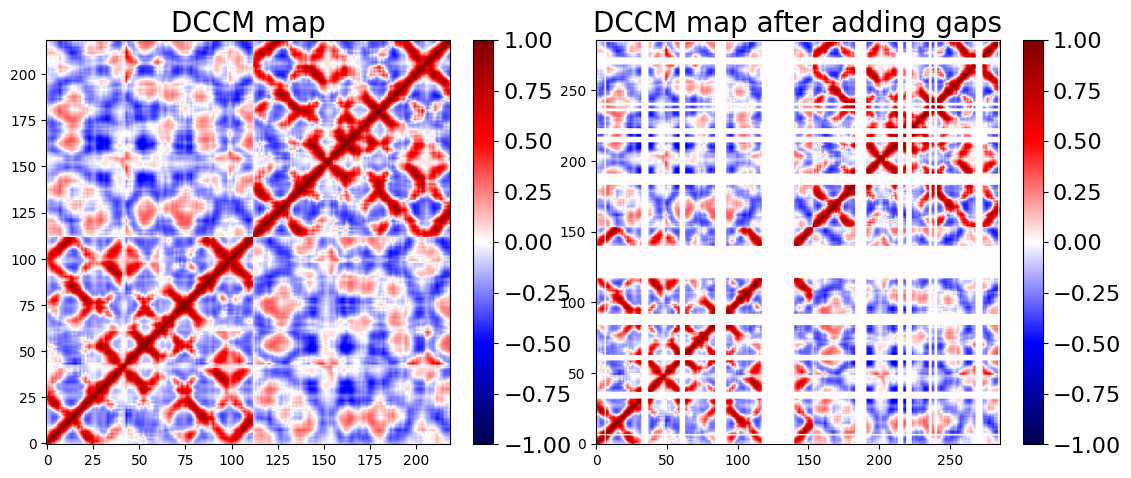

In [38]:
title_size = 20

input_shape = train_x.shape[-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.25))
im1 = ax1.imshow(raw_imgs[6], origin='lower', cmap='seismic', norm=CenteredNorm())
im2 = ax2.imshow(train_x[6].reshape(input_shape, input_shape), origin='lower', cmap='seismic', norm=CenteredNorm())

ax1.set_title('DCCM map', size=title_size)
ax2.set_title('DCCM map after adding gaps', size=title_size)

cb1 = plt.colorbar(im1, ax=ax1, fraction=0.045)
cb2 = plt.colorbar(im2, ax=ax2, fraction=0.045)

ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)
cb1.ax.tick_params(labelsize=16) 
cb2.ax.tick_params(labelsize=16) 

plt.show()

In [48]:
train_x[1]

array([[ 1.        ,  0.82101524,  0.71791194, ..., -0.14447678,
         0.        , -0.11230865],
       [ 0.82101524,  1.        ,  0.83952354, ..., -0.1882406 ,
         0.        , -0.14615266],
       [ 0.71791194,  0.83952354,  1.        , ..., -0.26439908,
         0.        , -0.20887339],
       ...,
       [-0.14447678, -0.1882406 , -0.26439908, ...,  1.        ,
         0.        ,  0.95754007],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.11230865, -0.14615266, -0.20887339, ...,  0.95754007,
         0.        ,  1.        ]])

# Training

## Import

In [63]:
import numpy as np
import torch
from torch.nn import MSELoss
from torch.optim import Adam

from adabelief_pytorch import AdaBelief
from sklearn.model_selection import train_test_split

## Split data

In [30]:
def create_test_set(train_x, train_y, test_size=None, random_state=0):
    r"""Creates the test set given a set of input images and their corresponding labels.

    Parameters
    ----------
    train_x: numpy.ndarray
        Input normal mode correlation maps.
    train_y: numpy.ndarray
        Labels.
    test_size: float
        Fraction of original samples to be included in the test set.
    random_state: int
        Set lot number.

    Returns
    -------
    train_x: torch.Tensor
        Training inputs.
    test_x: torch.Tensor
        Test inputs.
    train_y: torch.Tensor
        Training labels. 
    test_y: torch.Tensor
        Test labels.

    """

    # Splitting
    indices = np.arange(len(train_x))
    train_x, test_x, train_y, test_y, indices_train, indices_test = train_test_split(train_x, train_y, indices, test_size=0.023, random_state=23)

    # Converting to tensors
    train_x = train_x.reshape(train_x.shape[0], 1, train_x.shape[1], train_x.shape[1])
    train_x = train_x.astype(np.float32)
    train_x  = torch.from_numpy(train_x)
    train_y = train_y.astype(np.float32).reshape(train_y.shape[0], 1)
    train_y = torch.from_numpy(train_y)

    test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[2], test_x.shape[2])
    test_x = test_x.astype(np.float32)
    test_x  = torch.from_numpy(test_x)
    test_y = test_y.astype(np.float32).reshape(test_y.shape[0], 1, 1)
    test_y = torch.from_numpy(test_y)

    return train_x, test_x, train_y, test_y, indices_train, indices_test

In [32]:
train_x, test_x, train_y, test_y, idx_tr, idx_te = create_test_set(train_x, train_y, test_size=0.05)

In [64]:
train_x.shape

torch.Size([27, 1, 250, 250])

## Model CNN

In [37]:
import numpy as np
import torch
from torch.nn import Linear, ReLU, Conv2d, MaxPool2d, Module

def create_model(n_filters=2, filter_size=4, pooling_size=1, input_shape=281, l1_lambda=0.002, mode='full'):
    model = {
        'n_filters': n_filters,
        'filter_size': filter_size,
        'pooling_size': pooling_size,
        'input_shape': input_shape,
        'l1_lambda': l1_lambda,
        'mode': mode
    }
    if mode == 'full':
        model['fully_connected_input'] = n_filters * ((input_shape - filter_size + 1) // pooling_size) ** 2
        model['conv1'] = Conv2d(1, n_filters, filter_size)
        model['pool'] = MaxPool2d(pooling_size, pooling_size)
        model['relu'] = ReLU()
    else:
        model['fully_connected_input'] = input_shape ** 2
    model['fc1'] = Linear(model['fully_connected_input'], 1, bias=False)
    return model

def forward_pass(model, x):
    if model['mode'] == 'full':
        x = model['conv1'](x) + torch.transpose(model['conv1'](x), 2, 3)
        x = model['relu'](x)
        inter = x = model['pool'](x)
    else:
        inter = x
    x = x.view(x.size(0), -1)
    x = model['fc1'](x)
    return x.float(), inter

def l1_regularization_loss(model):
    l1_loss = torch.tensor(0.0)
    for key in model:
        if 'conv1' in key or 'fc1' in key:
            l1_loss += torch.norm(model[key].weight, p=1)
    return model['l1_lambda'] * l1_loss

In [44]:
import numpy as np
import torch
from torch.nn import Linear, ReLU, Conv2d, MaxPool2d, Module

class ANTIPASTI(Module):
    r"""Predicting the binding affinity of an antibody from its normal mode correlation map.

    Parameters
    ----------
    n_filters: int
        Number of filters in the convolutional layer.
    filter_size: int
        Size of filters in the convolutional layer.
    pooling_size: int
        Size of the max pooling operation.
    input_shape: int
        Shape of the normal mode correlation maps.
    l1_lambda: float
        Weight of L1 regularisation.
    mode: str
        To use the full model, provide ``full``. Otherwise, ANTIPASTI corresponds to a linear map.

    """
    def __init__(
            self,
            n_filters=2,
            filter_size=4,
            pooling_size=1,
            input_shape=281,
            l1_lambda=0.002,
            mode='full',
    ):
        super(ANTIPASTI, self).__init__()
        self.n_filters = n_filters
        self.filter_size = filter_size
        self.pooling_size = pooling_size
        self.input_shape = input_shape
        self.mode = mode
        if self.mode == 'full':
            self.fully_connected_input = n_filters * ((input_shape-filter_size+1)//pooling_size) ** 2
            self.conv1 = Conv2d(1, n_filters, filter_size)
            self.pool = MaxPool2d((pooling_size, pooling_size))
            self.relu = ReLU()
        else:
            self.fully_connected_input = self.input_shape ** 2
        self.fc1 = Linear(self.fully_connected_input, 1, bias=False)
        self.l1_lambda = l1_lambda

    def forward(self, x):
        r"""Model's forward pass.

        Returns
        -------
        output: torch.Tensor
            Predicted binding affinity.
        inter_filter: torch.Tensor
            Filters before the fully-connected layer.
            
        """
        inter = x
        if self.mode == 'full':
            x = self.conv1(x) + torch.transpose(self.conv1(x), 2, 3)
            x = self.relu(x)
            inter = x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x.float(), inter

    def l1_regularization_loss(self):
        l1_loss = torch.tensor(0.0)
        for param in self.parameters():
            l1_loss += torch.norm(param, p=1)
        return self.l1_lambda * l1_loss

In [71]:
n_filters = 4
filter_size = 4
pooling_size = 2
learning_rate = 1e-4


# Defining the model, optimiser and loss function
model = ANTIPASTI(n_filters=n_filters, filter_size=filter_size, pooling_size=pooling_size, input_shape=input_shape, l1_lambda=0.002)
criterion = MSELoss() 
optimiser = AdaBelief(model.parameters(), lr=learning_rate, weight_decay=False, eps=1e-8, print_change_log=False) 
# optimiser = Adam(model.parameters(), lr=learning_rate)
print(model)

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
ANTIPASTI(
  (conv1): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=60516, out_features=1, bias=False)
)


### Training

In [50]:
from torch.autograd import Variable

In [51]:
def training_step(model, criterion, optimiser, train_x, test_x, train_y, test_y, train_losses, test_losses, epoch, batch_size, verbose):
    r"""Performs a training step.
    
    Parameters
    ----------
    model: antipasti.model.model.ANTIPASTI
        The model class, i.e., ``ANTIPASTI``.
    criterion: torch.nn.modules.loss.MSELoss
        It calculates a gradient according to a selected loss function, i.e., ``MSELoss``.
    optimiser: adabelief_pytorch.AdaBelief.AdaBelief
        Method that implements an optimisation algorithm.
    train_x: torch.Tensor
        Training normal mode correlation maps.
    test_x: torch.Tensor
        Test normal mode correlation maps.
    train_y: torch.Tensor
        Training labels. 
    test_y: torch.Tensor
        Test labels.
    train_losses: list 
        The current history of training losses.
    test_losses: list 
        The current history of test losses.
    epoch: int
        Of value ``e`` if the dataset has gone through the model ``e`` times.
    batch_size: int
        Number of samples that pass through the model before its parameters are updated.
    verbose: bool
        ``True`` to print the losses in each epoch.
    
    Returns
    -------
    train_losses: list 
        The history of training losses after the training step.
    test_losses: list 
        The history of test losses after the training step.
    inter_filter: torch.Tensor
        Filters before the fully-connected layer.
    y_test: torch.Tensor
        Ground truth test labels.
    output_test: torch.Tensor
        The predicted test labels. 

    """   
    tr_loss = 0
    tr_mse = 0
    x_train, y_train = Variable(train_x), Variable(train_y)
    x_test, y_test = Variable(test_x), Variable(test_y)

    # Filters before the fully-connected layer
    size_inter = int(np.sqrt(model.fully_connected_input/model.n_filters))
    inter_filter = np.zeros((x_train.size()[0], model.n_filters, size_inter, size_inter))
    if model.mode != 'full':
        inter_filter = np.zeros((x_train.size()[0], 1, model.input_shape, model.input_shape))
    permutation = torch.randperm(x_train.size()[0])

    for i in range(0, x_train.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        
        # Training output
        output_train, inter_filters = model(batch_x)
        
        # Picking the appropriate filters before the fully-connected layer
        inter_filters_detached = inter_filters.detach().clone()
        inter_filter[i:i+batch_size] = inter_filters_detached.numpy()

        # Training loss, clearing gradients and updating weights
        optimiser.zero_grad()
        l1_loss = model.l1_regularization_loss()
        mse_loss = criterion(output_train[:, 0], batch_y[:, 0])
        loss_train = mse_loss + l1_loss
        if verbose:
            print(l1_loss)
        loss_train.backward()
        optimiser.step()
        # Adding batch contribution to training loss
        tr_loss += loss_train.item() * batch_size / x_train.size()[0]
        tr_mse += mse_loss * batch_size / x_train.size()[0]

    train_losses.append(tr_loss)
    loss_test = 0
    output_test = []

    with torch.no_grad():
        for i in range(x_test.size()[0]):
            optimiser.zero_grad()
            output_t, _ = model(x_test[i].reshape(1, 1, model.input_shape, model.input_shape))
            l1_loss = model.l1_regularization_loss()
            loss_t = criterion(output_t[:, 0], y_test[i][:, 0])
            loss_test += loss_t.item() / x_test.size()[0]
            if verbose:
                print(output_t)
                print(y_test[i])
                print('------------------------')
            output_test.append(output_t[:,0].detach().numpy())
    test_losses.append(loss_test)
    
    # Training and test losses
    if verbose:
        print('Epoch : ', epoch+1, '\t', 'train loss: ', tr_loss, 'train MSE: ', tr_mse, 'test MSE: ', loss_test)

        
    return train_losses, test_losses, inter_filter, y_test, output_test

In [52]:
def training_routine(model, criterion, optimiser, train_x, test_x, train_y, test_y, n_max_epochs=120, max_corr=0.87, batch_size=32, verbose=True):
    r"""Performs a chosen number of training steps.
    
    Parameters
    ----------
    model: antipasti.model.model.ANTIPASTI
        The model class, i.e., ``ANTIPASTI``.
    criterion: torch.nn.modules.loss.MSELoss
        It calculates a gradient according to a selected loss function, i.e., ``MSELoss``.
    optimiser: adabelief_pytorch.AdaBelief.AdaBelief
        Method that implements an optimisation algorithm.
    train_x: torch.Tensor
        Training normal mode correlation maps.
    test_x: torch.Tensor
        Test normal mode correlation maps.
    train_y: torch.Tensor
        Training labels. 
    test_y: torch.Tensor
        Test labels.
    n_max_epochs: int
        Number of times the whole dataset goes through the model.
    max_corr: float
        If the correlation coefficient exceeds this value, the training routine is terminated.
    batch_size: int
        Number of samples that pass through the model before its parameters are updated.
    verbose: bool
        ``True`` to print the losses in each epoch.
    
    Returns
    -------
    train_losses: list 
        The history of training losses after the training routine.
    test_losses: list 
        The history of test losses after the training routine.
    inter_filter: torch.Tensor
        Filters before the fully-connected layer.
    y_test: torch.Tensor
        Ground truth test labels.
    output_test: torch.Tensor
        The predicted test labels. 

    """   
    train_losses = []
    test_losses = []

    for epoch in range(n_max_epochs):
        train_losses, test_losses, inter_filter, y_test, output_test = training_step(model, criterion, optimiser, train_x, test_x, train_y, test_y, train_losses, test_losses, epoch, batch_size, verbose)

        # Computing and printing the correlation coefficient
        corr = np.corrcoef(np.array(output_test).T, y_test[:,0].detach().numpy().T)[1,0]
        if verbose:
            print('Corr: ' + str(corr))
        if corr > max_corr:
            break
    
    return train_losses, test_losses, inter_filter, y_test, output_test

In [66]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

60584

In [72]:
train_losses = []
test_losses = []

In [73]:
model.train()
n_max_epochs = 50 # This is just a super short example. You can increase this.
max_corr = 0.87
batch_size = 32

train_loss, test_loss, inter_filter, y_test, output_test = training_routine(model, criterion, optimiser, train_x, test_x, train_y, test_y, n_max_epochs=n_max_epochs, max_corr=max_corr, batch_size=batch_size)

# Saving the losses
train_losses.extend(train_loss)
test_losses.extend(test_loss)

tensor(0.2633, grad_fn=<MulBackward0>)
tensor([[-11.7249]])
tensor([[-8.1024]])
------------------------
Epoch :  1 	 train loss:  86.74459273726852 train MSE:  tensor(86.4325, grad_fn=<AddBackward0>) test MSE:  13.122640609741211
Corr: nan
tensor(0.2672, grad_fn=<MulBackward0>)
tensor([[-15.2354]])
tensor([[-8.1024]])
------------------------
Epoch :  2 	 train loss:  11.808368824146411 train MSE:  tensor(11.4917, grad_fn=<AddBackward0>) test MSE:  50.879478454589844
Corr: nan
tensor(0.2704, grad_fn=<MulBackward0>)
tensor([[-13.6986]])
tensor([[-8.1024]])
------------------------
Epoch :  3 	 train loss:  37.369547526041664 train MSE:  tensor(37.0491, grad_fn=<AddBackward0>) test MSE:  31.317785263061523
Corr: nan
tensor(0.2702, grad_fn=<MulBackward0>)
tensor([[-10.9057]])
tensor([[-8.1024]])
------------------------
Epoch :  4 	 train loss:  23.047786006221063 train MSE:  tensor(22.7275, grad_fn=<AddBackward0>) test MSE:  7.858912944793701
Corr: nan
tensor(0.2690, grad_fn=<MulBackwar

In [57]:
   print("Unique y_test:", np.unique(y_test.detach().numpy()))
   print("Unique output_test:", np.unique(np.array(output_test)))

Unique y_test: [-8.102373]
Unique output_test: [-8.350439]


In [58]:
   print("NaN in y_test:", np.isnan(y_test.detach().numpy()).any())
   print("NaN in output_test:", np.isnan(np.array(output_test)).any())
   print("Inf in y_test:", np.isinf(y_test.detach().numpy()).any())
   print("Inf in output_test:", np.isinf(np.array(output_test)).any())

NaN in y_test: False
NaN in output_test: False
Inf in y_test: False
Inf in output_test: False


In [59]:
   for name, param in model.named_parameters():
       if param.requires_grad:
           print(name, param.grad)

conv1.weight None
conv1.bias None
fc1.weight None


### Ploting

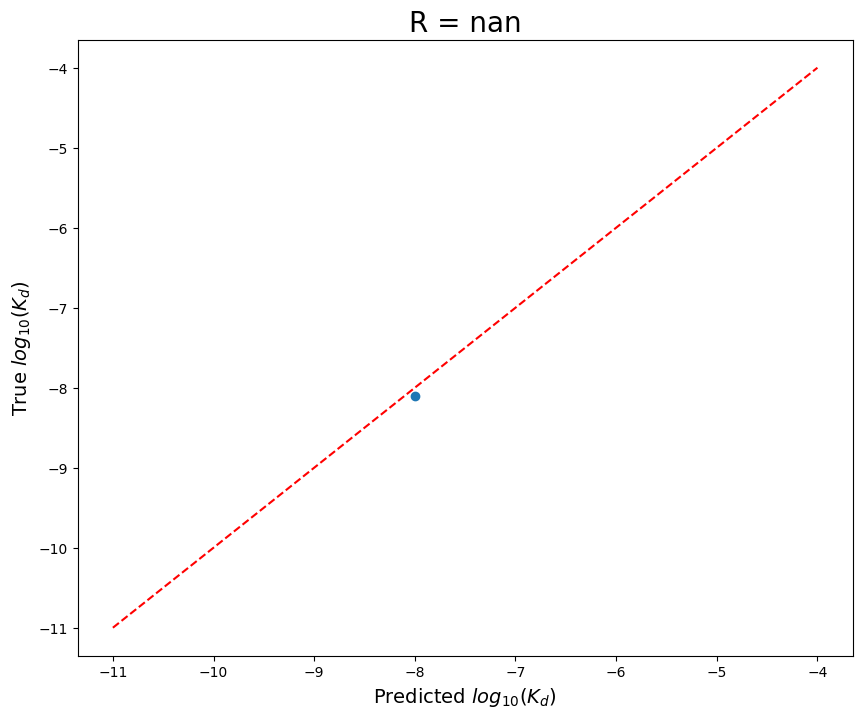

In [54]:
font_size = 14

fig = plt.figure(figsize=(10, 8))
plt.scatter(np.array(output_test), y_test[:,0].detach().numpy())
corr = np.corrcoef(np.array(output_test).T, y_test[:,0].detach().numpy().T)[1,0]
plt.plot([-11,-4],[-11,-4], c='r', linestyle='dashed')
plt.title('R = '+str(corr), size=title_size)
plt.xlabel('Predicted $log_{10}$($K_d$)', size=font_size)
plt.ylabel('True $log_{10}$($K_d$)', size=font_size)
plt.show()

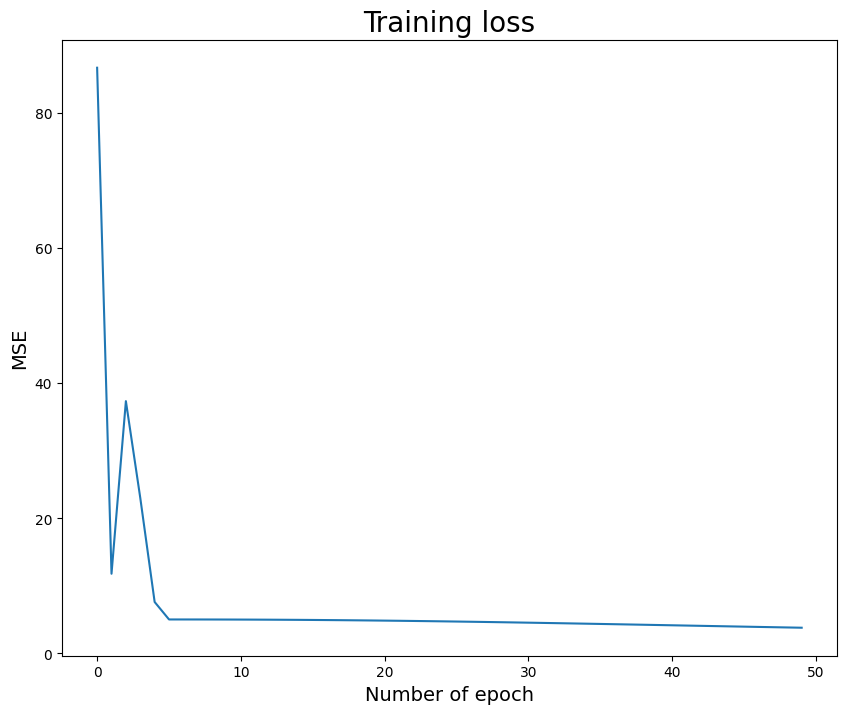

In [74]:
fig = plt.figure(figsize=(10, 8))
plt.plot([train_losses[i] for i in range(len(train_losses))])
plt.title('Training loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

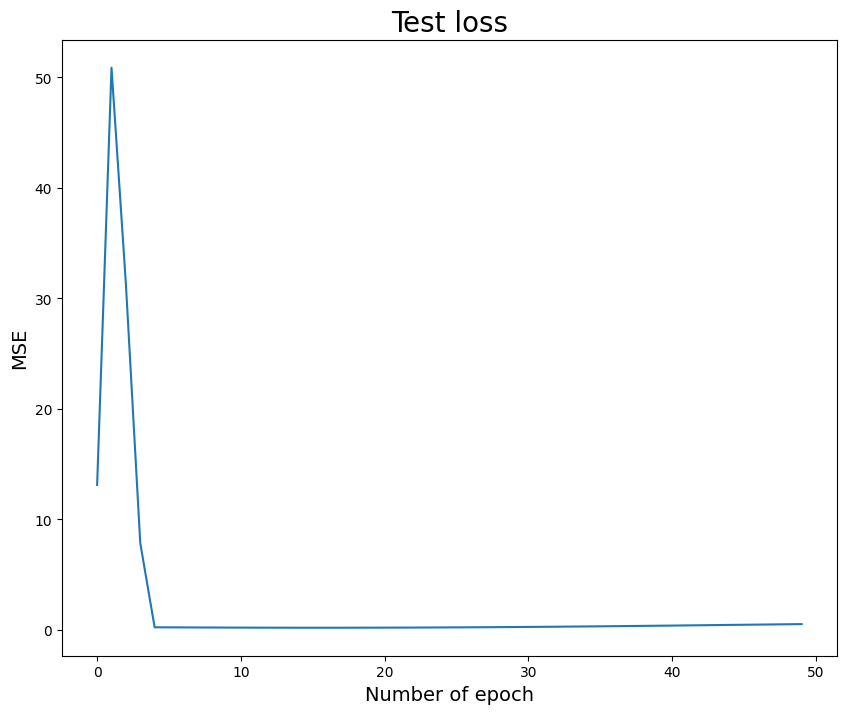

In [75]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[i] for i in range(len(test_losses))])
plt.title('Test loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()